## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)
    
    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        
        # Commenting out for faster run time
        #cv2.imshow('img',img)
        #cv2.waitKey(500)

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)        


#Defining the methods that will be used at the pipeline for processing
def undistort_image( image ):
    # This method is not really useful, but lets let it here as a reminder
    return cv2.undistort(image, mtx, dist, None, mtx)


sample_image = cv2.imread('camera_cal/calibration1.jpg')
undistorted_image =  undistort_image( sample_image )

cv2.imwrite( 'output_images/calibrated1.jpg', undistorted_image)

# Image undistortion example. This will load an sample image and display the image after distortion correction
raw_image = cv2.imread( 'test_images/straight_lines1.jpg' )
und_image = undistort_image(raw_image )

cv2.imwrite( 'output_images/und_straight_lines1.jpg', und_image)

True

## Usefull classes.
As this proccess has a state to be mantained and updated, those classes will contain the method for the processing pipeline and keep the context sane

In [2]:
from numpy import linalg

#Meters per pixels constants
my = 10/720
mx = 3.7/700

# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None  
        
        self.n = 5
        self.counter = 0
        
        self.last_fits = np.zeros( [self.n, 3 ], np.float32 )
        
        
    def set_last_detection( self, img_shape, x_pixels, y_pixels ):
        self.allx = x_pixels
        self.ally = y_pixels
        
        #Validating fit
        pixels_diff = np.max( y_pixels ) - np.min( y_pixels ) 
        
        if ( x_pixels.size > 0 and pixels_diff > img_shape[0]/2.0 ):
        
            self.current_fit, self.recent_xfitted, self.ploty = fit_poly( img_shape, self.allx, self.ally )
        
        
            if( self.counter > 5 ):
                self.diffs = np.abs( self.current_fit - self.best_fit )
            
            
            index = self.counter % self.last_fits.shape[0]
            self.last_fits[ index ] = self.current_fit
            self.counter = self.counter + 1
        
            fit_sum = np.array( [0,0,0], np.float32 )
            for i in range( 0, self.n ):
                fit_sum =  fit_sum + self.last_fits[ i ]
                if( i > self.counter ):
                    break
        
        
            self.detected = True
            self.best_fit = fit_sum/float( self.n )
            
            A = self.best_fit[0]
            B = self.best_fit[1]
            
            y = 360
            
            A = A*( mx/(my ** 2) )
            B = B*( mx/my )
            
            self.radius_of_curvature = ( (1.0+(2*A*y + B)**2.0)**(1.5) )/np.absolute(2*A)
        
        
        # Generate x and y values for plotting
        ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
        self.bestx = np.poly1d( self.best_fit )(ploty)
        #Now, we can do some king of processing

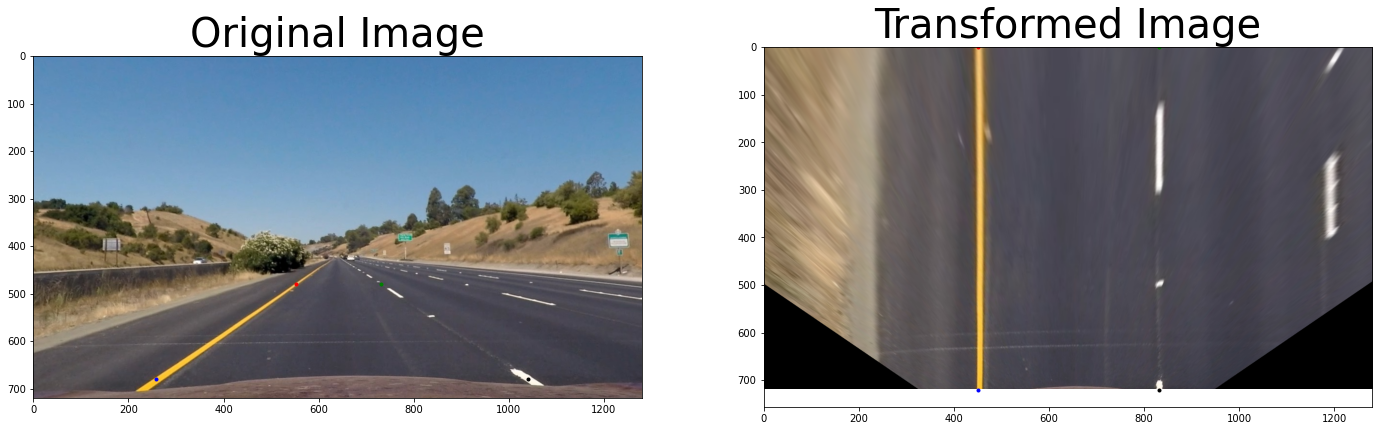

In [3]:
# This portion will help out to define the points to the perspective transform
# After this chunk of code, we will have the matrix M
image = cv2.imread( 'test_images/straight_lines1.jpg' )

src = np.float32( [ [ 553, 480 ],
                    [ 731, 480 ], 
                    [ 258, 680 ],
                    [ 1040,680 ] ] )

w = image.shape[1]
h = image.shape[0]

dst = np.float32( [ [ 450,   0 ], 
                    [ w-450, 0 ], 
                    [ 450,   h ], 
                    [ w-450, h ] ] )

M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)

def perspective_transform( image ):
    img_size = ( image.shape[1], image.shape[0] )
    return cv2.warpPerspective(image, M, img_size, flags=cv2.INTER_LINEAR)

image = undistort_image( image )

warped = perspective_transform(image)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))


ax1.set_title('Original Image', fontsize=40)
ax1.imshow( cv2.cvtColor(image, cv2.COLOR_BGR2RGB) )
ax1.plot( *src[0], '.r')
ax1.plot( *src[1], '.g')
ax1.plot( *src[2], '.b')
ax1.plot( *src[3], '.k')

ax2.set_title('Transformed Image', fontsize=40)
ax2.imshow( cv2.cvtColor(warped, cv2.COLOR_BGR2RGB) )
ax2.plot( *dst[0], '.r')
ax2.plot( *dst[1], '.g')
ax2.plot( *dst[2], '.b')
ax2.plot( *dst[3], '.k')



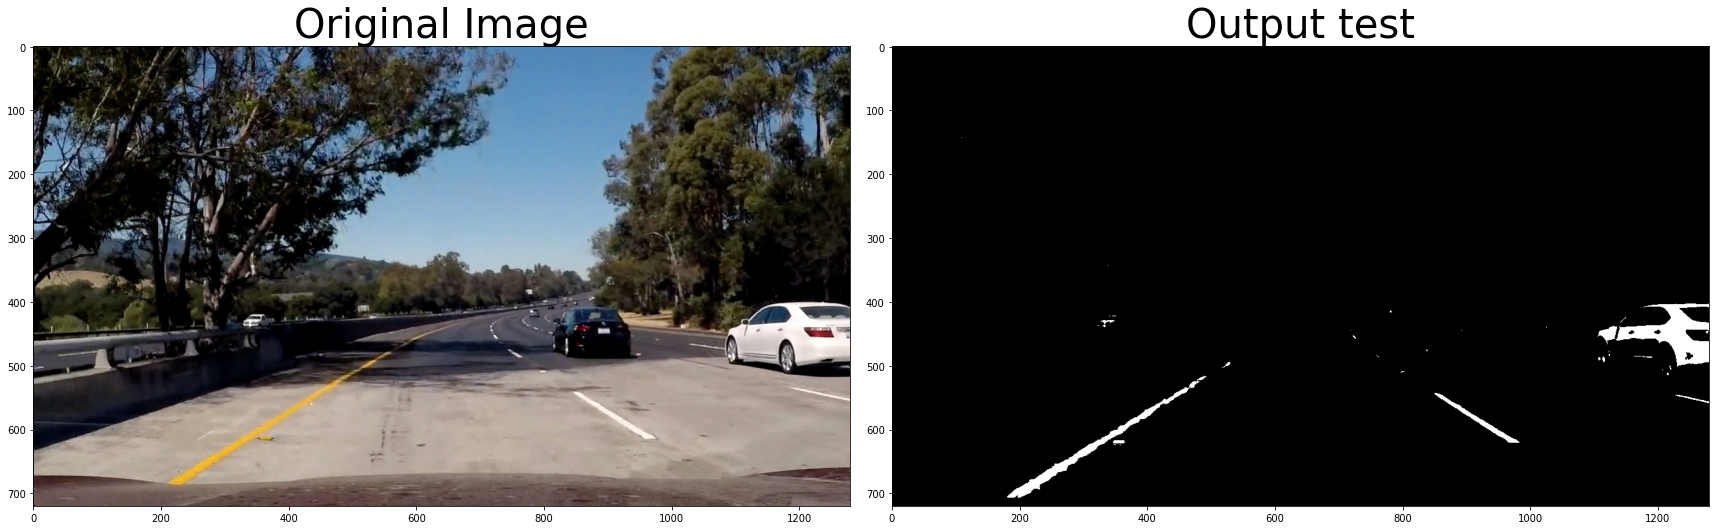

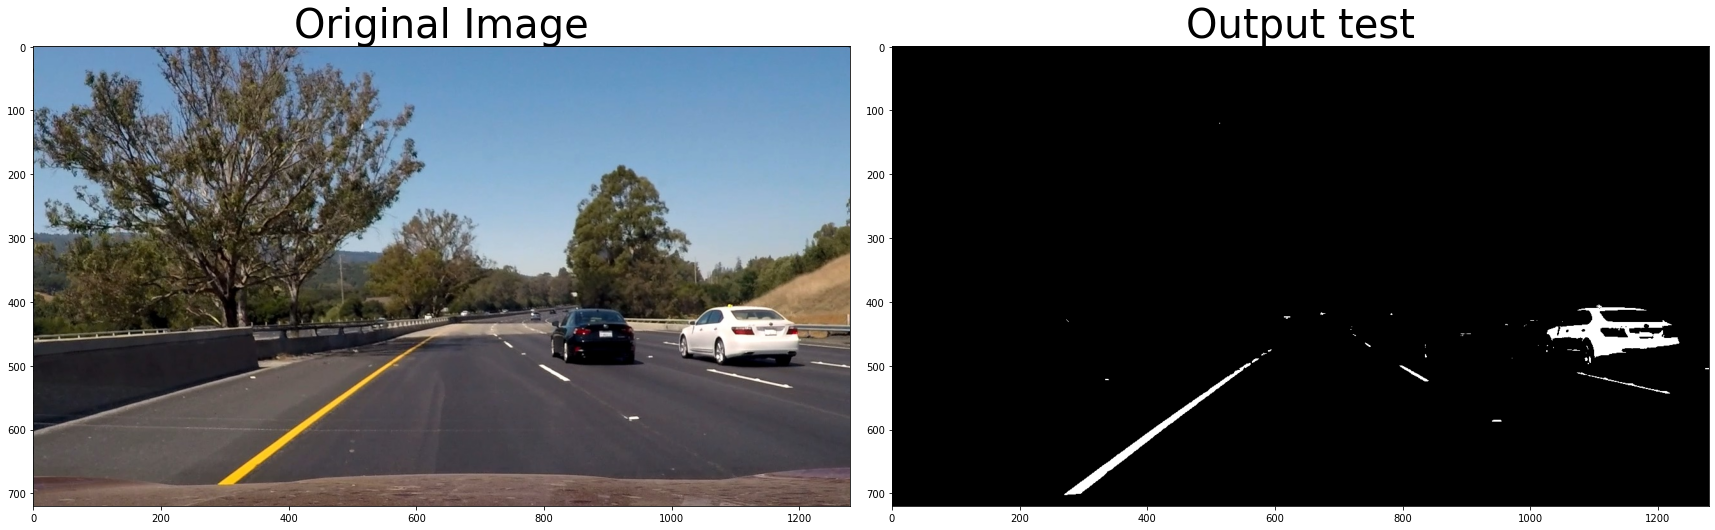

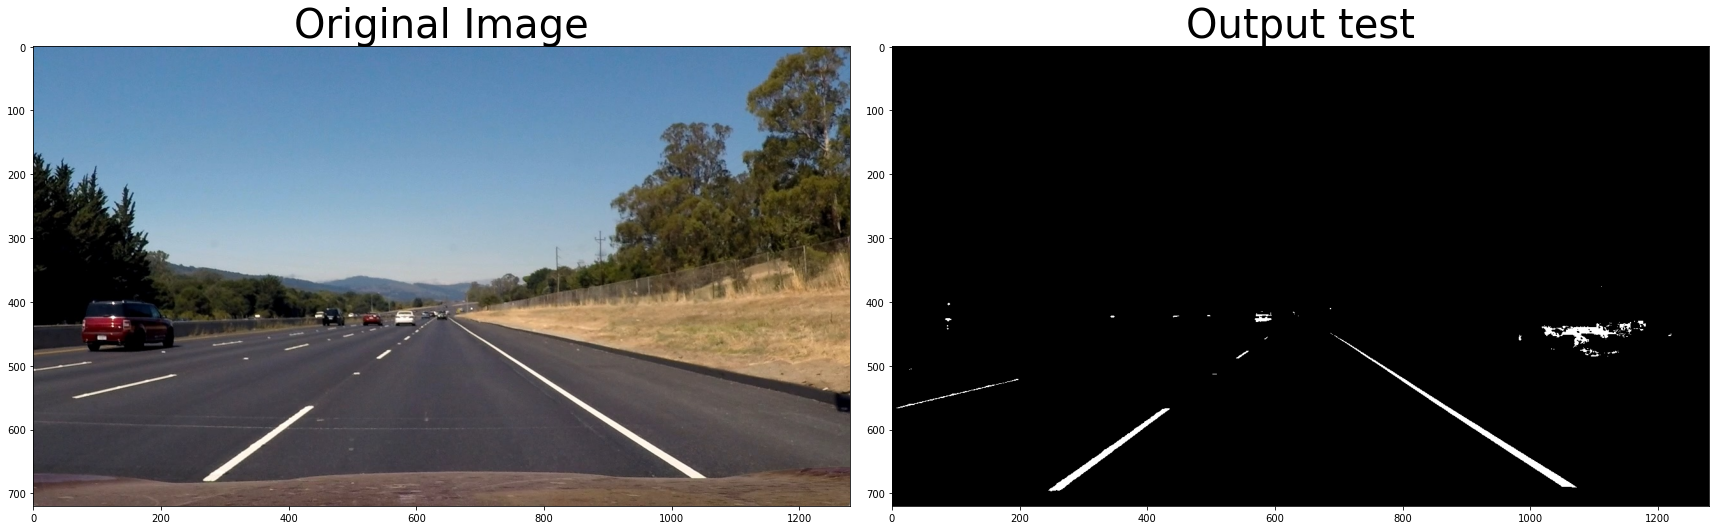

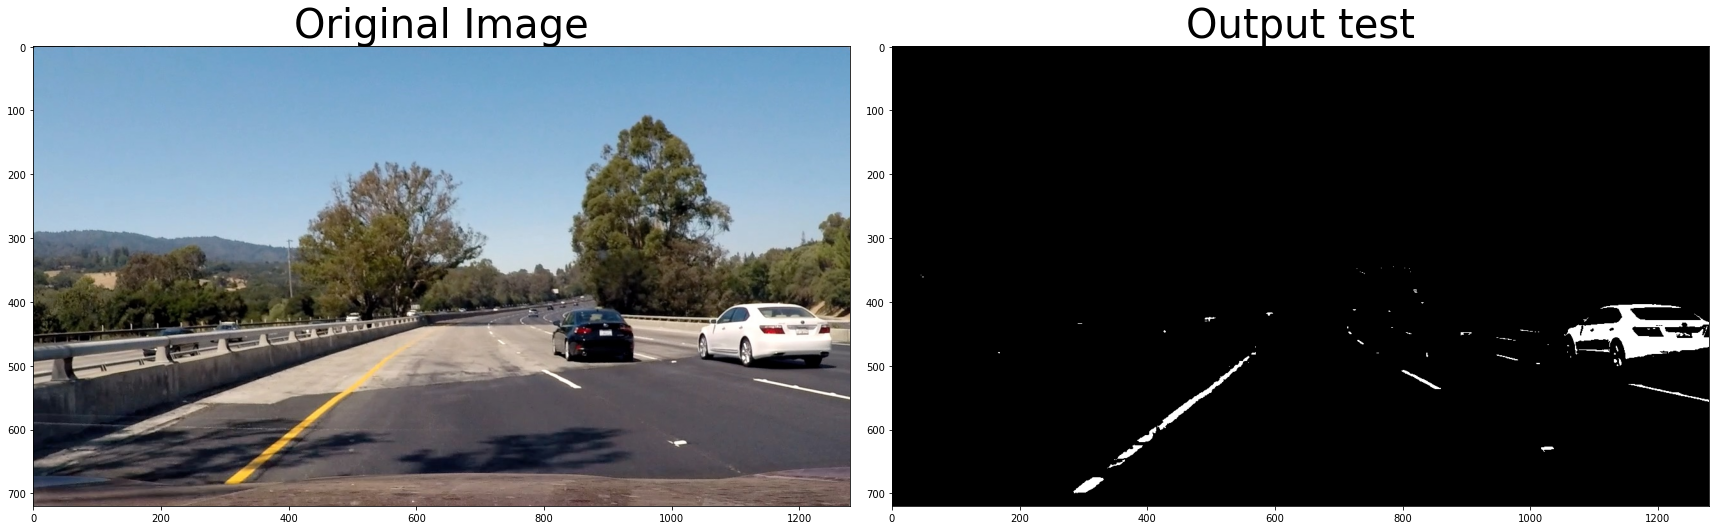

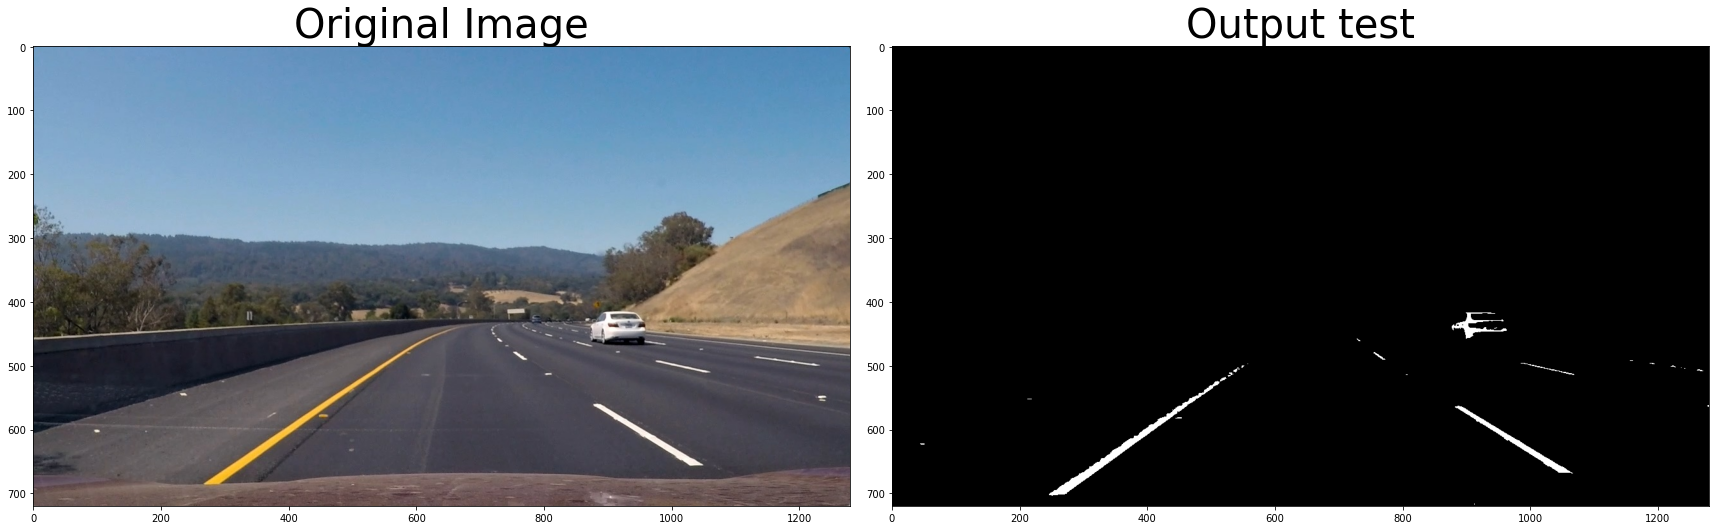

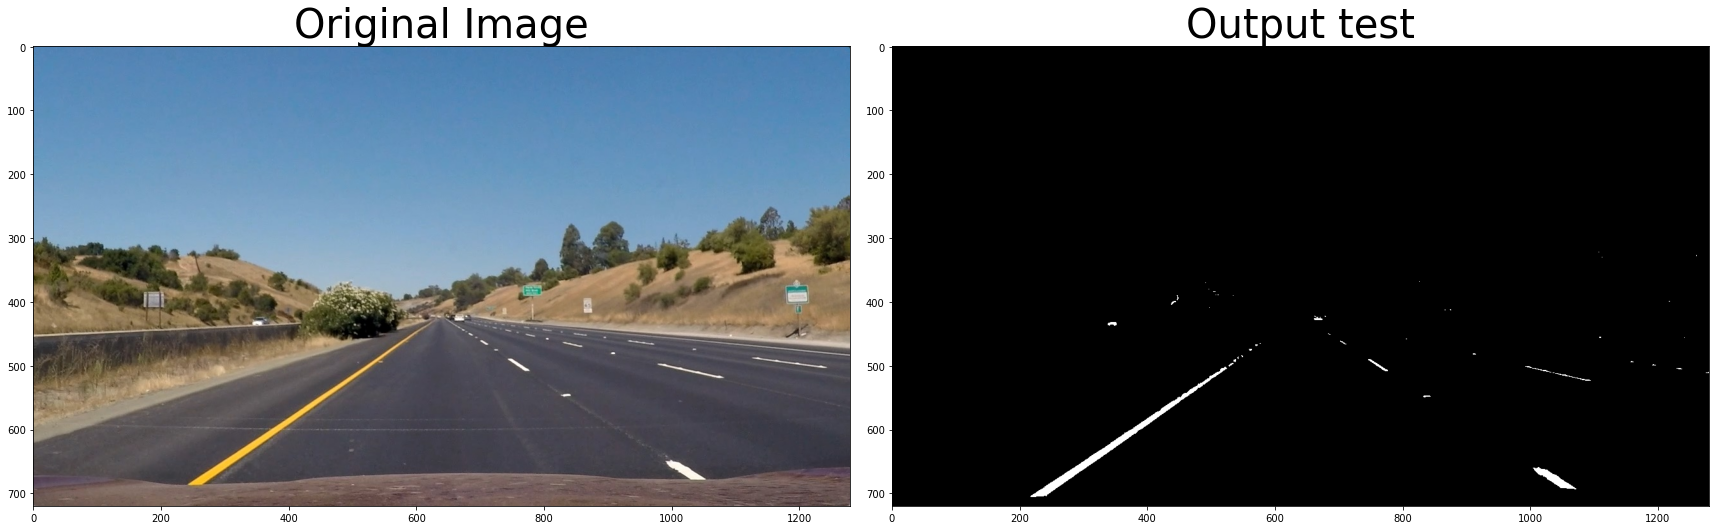

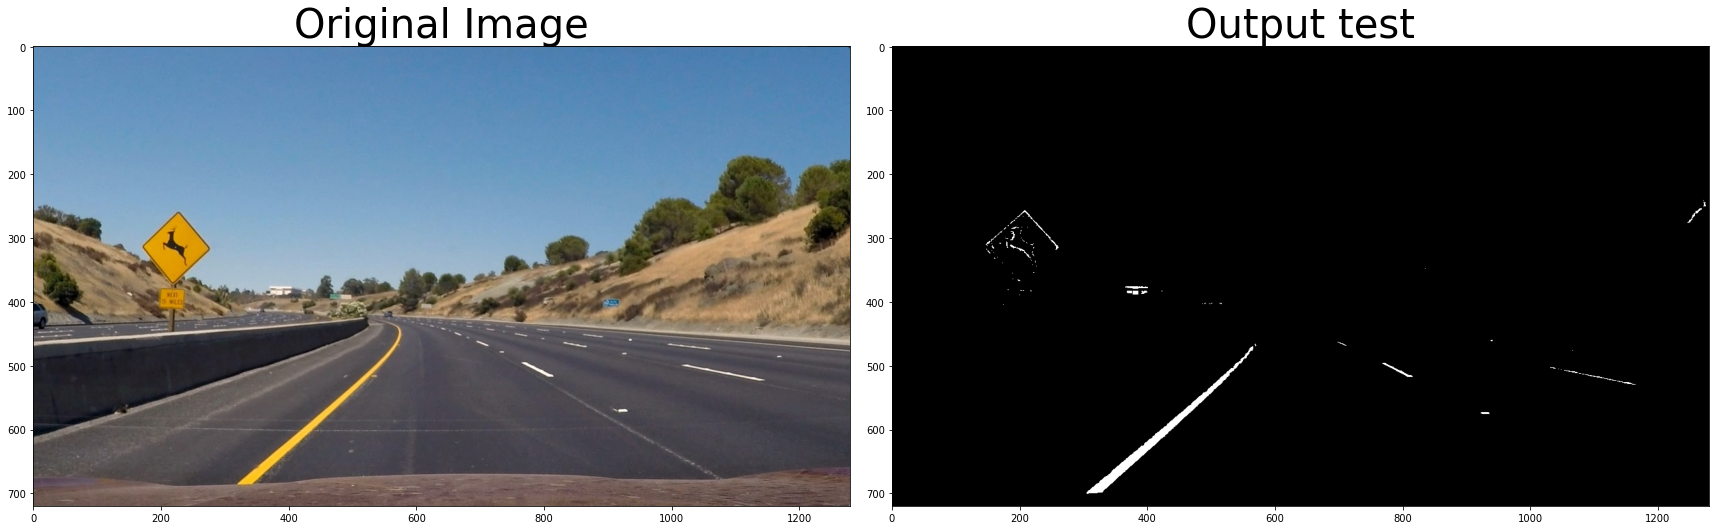

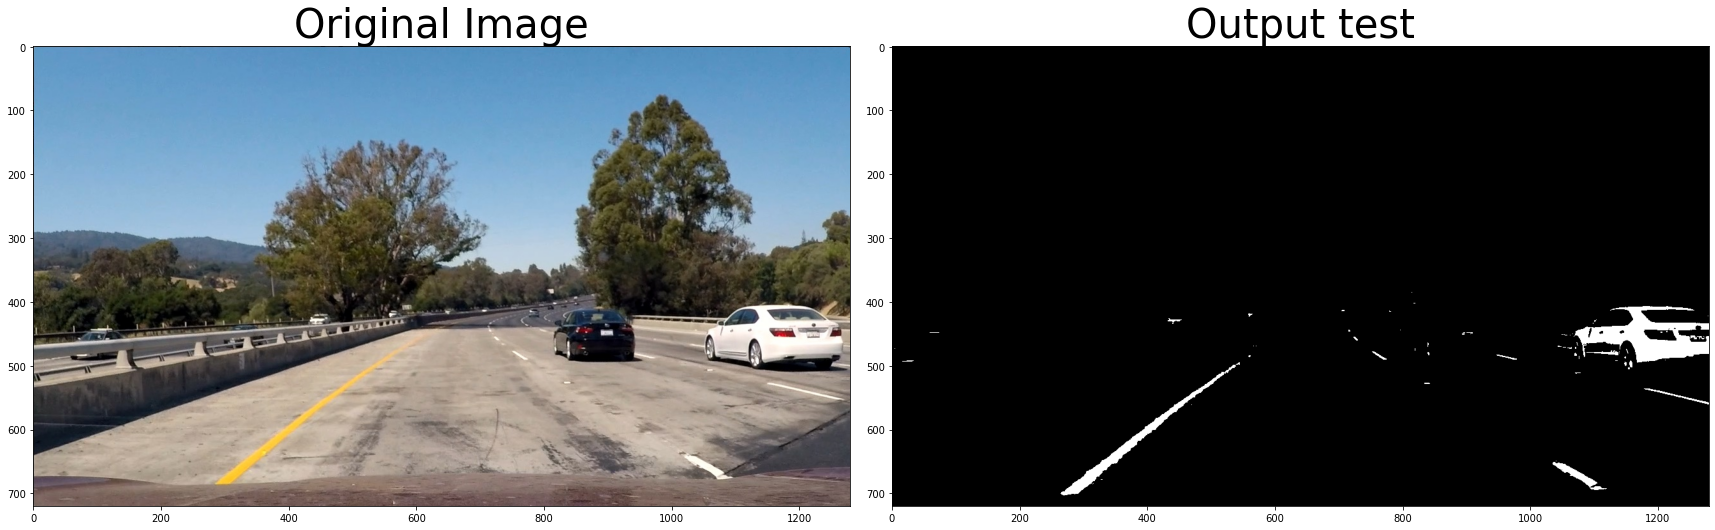

In [4]:
## Copying the proposal functions for the sobel operator to be used later
def abs_sobel_thresh(img, orient='x', thresh=(0, 255) ):
    
    # 1) The supossition is that img alread carrys the correcct channel
    gray = np.copy(img)
    
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    
    sobel = 0
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    elif orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8( 255*abs_sobel/np.max( abs_sobel ) )
    
    sbinary = np.zeros_like(scaled_sobel)
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    
    sbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return sbinary


def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = np.copy( img )
    
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel( gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel )
    sobely = cv2.Sobel( gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel )
    # 3) Calculate the magnitude 
    abs_sobelxy = np.sqrt( sobelx**2 + sobely**2 )
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scale_factor = np.max(abs_sobelxy)/255 
    scaled_sobel = (abs_sobelxy/scale_factor).astype(np.uint8) 
    # 5) Create a binary mask where mag thresholds are met
    sbinary = np.zeros_like(scaled_sobel)
    sbinary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return sbinary


def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = np.copy(img)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel( gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel )
    sobely = cv2.Sobel( gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel )
    # 3) Calculate the direction
    dir_sobel_xy = np.arctan2( np.absolute( sobely ), np.absolute( sobelx ) )
    
    # 5) Create a binary mask where dir thresholds are met
    sbinary = np.zeros_like(dir_sobel_xy)
    sbinary[( dir_sobel_xy >= thresh[0]) & ( dir_sobel_xy <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return sbinary


def apply_bin_threshold( img, bin_threshold=( 20, 255 ) ):
    bin_img = np.zeros_like( img )
    bin_img[ ( img >= bin_threshold[0] ) & ( img <= bin_threshold[1] ) ] = 1
    
    return bin_img


def input_pipeline( image ):
    img = np.copy( image )
    img = undistort_image( img );
    
    #Converting to HLS
    hls = cv2.cvtColor( img, cv2.COLOR_RGB2HLS ).astype(np.float)
    
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
        
    #Extracting white portions of the image
    l_binary = np.zeros_like( l_channel )
    l_binary[ ( l_channel > 220 ) & (l_channel <= 255 )] = 1
    
    #bin_rgb_w = apply_bin_threshold( l_channel )
    #mag_rgb_w = mag_thresh( l_binary, sobel_kernel=15, mag_thresh=( 190, 255 ) )    
    #dir_rgb_w = dir_threshold( l_binary, sobel_kernel=15, thresh=( 0.7, 1.3 ) )
    #binary_white = np.zeros_like( dir_rgb_w )
    #binary_white[ ( ( mag_rgb_w == 1 ) & ( dir_rgb_w == 1 ) ) ] = 1
    
    #Based on: https://medium.com/@tjosh.owoyemi/finding-lane-lines-with-colour-thresholds-beb542e0d839
    #It's yellow extraction seems to work pretty good
    
    #Extracting yellow portions of the line
    lower = np.array([20,  120,  80],dtype="uint8")
    upper = np.array([45, 200, 255],dtype="uint8")
    
    mask = cv2.inRange( hls, lower, upper )
    hls_y = cv2.bitwise_and( image, image, mask=mask).astype( np.uint8 )
    hls_y = cv2.cvtColor( hls_y, cv2.COLOR_HLS2RGB )
    hls_y = cv2.cvtColor( hls_y, cv2.COLOR_RGB2GRAY )
    
    #sobelx_hls_y = mag_thresh( hls_y, orient='x', thresh=(20,120) )
    bin_hl_y = apply_bin_threshold( hls_y )
    
    #mag_hls_y = mag_thresh( hls_y, sobel_kernel=15, mag_thresh=( 190, 255 ) )
    #dir_hls_y = dir_threshold( hls_y, sobel_kernel=15, thresh=( 0.7, 1.3 ) )   
    #combine_hls_y = np.zeros_like( dir_hls_y )
    #combine_hls_y[ ( mag_hls_y == 1 ) & ( dir_hls_y == 1 ) ] = 1
        
    combined = np.zeros_like( bin_hl_y )    
    combined[ ( ( bin_hl_y == 1 ) | ( l_binary == 1 ) ) ] = 1   

    return( np.uint8( combined*255 ) )


testing = True

# Testing

if( testing ):
    images = glob.glob('test_images/*.jpg')

    for fname in images:

        image = cv2.imread(fname);
        warped = input_pipeline( cv2.cvtColor(image, cv2.COLOR_BGR2RGB) )

        # Plot the result
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
        f.tight_layout()

        ax1.set_title('Original Image', fontsize=40)
        ax1.imshow( cv2.cvtColor(image, cv2.COLOR_BGR2RGB) )

        ax2.set_title('Output test', fontsize=40)
        ax2.imshow( cv2.cvtColor(warped, cv2.COLOR_BGR2RGB ) )
        

    cv2.destroyAllWindows()

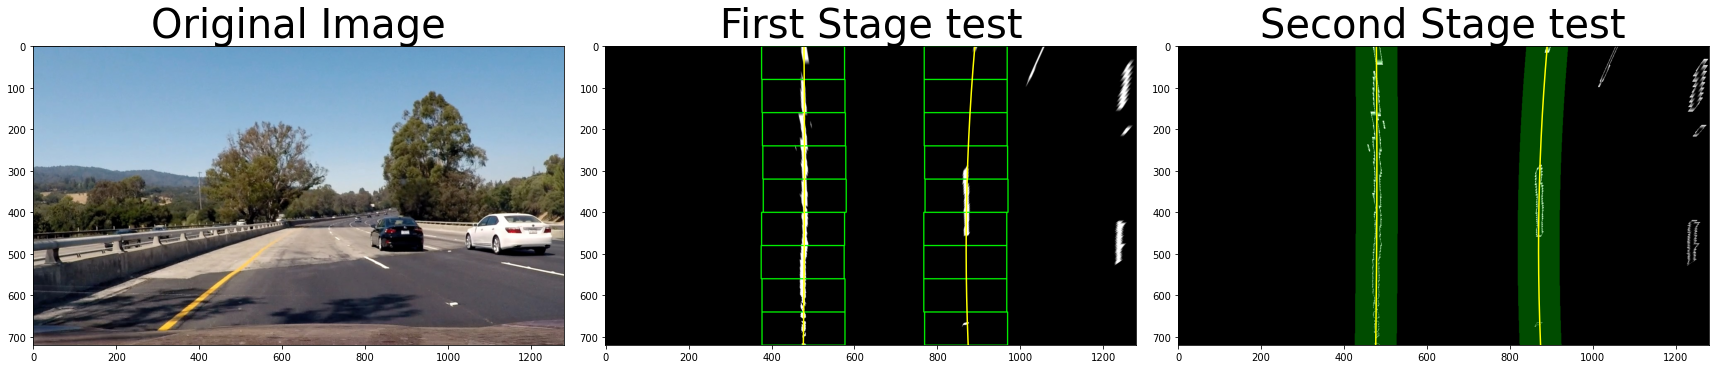

In [5]:
def find_lane_pixels(binary_warped):
    
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        
        win_xleft_low = leftx_current - margin 
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        left_lane_inds.append( good_left_inds )
        right_lane_inds.append( good_right_inds )
        
        if len( good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        
        
        if len( good_right_inds ) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))             
        

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def search_around_poly( binary_warped, left_fit, right_fit ):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 50

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
                    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    
    return leftx, lefty, rightx, righty


def fit_poly(img_shape, x, y ):
    fit = np.polyfit( y, x, 2)
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    fitx = np.poly1d(fit)(ploty)
    
    return fit, fitx, ploty


def draw_output( warped, undist, left_fitx, right_fitx, ploty ):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0])) 
    
    # Combine the result with the original image
    warped_small = cv2.resize(warped, ( int(warped.shape[0]/5), int(warped.shape[1]/5)) ) 
    warped_small_rgb = cv2.cvtColor( warped_small,cv2.COLOR_GRAY2RGB) 
    
    undist2 = np.copy( undist )
    undist2[ ( undist.shape[0] - warped_small_rgb.shape[0] ) : undist.shape[0], 0 : warped_small_rgb.shape[1], : ]  = warped_small_rgb
    
    return cv2.addWeighted(undist2, 1, newwarp, 0.3, 0)


#Testing the above pipeline
test_image = cv2.imread('test_images/test4.jpg')
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
test_warped = perspective_transform( input_pipeline( test_image ) )

#1st stage: Finding Lane Pixels
leftx, lefty, rightx, righty, out_img = find_lane_pixels( test_warped )
left_fit,  left_fitx,  left_ploty  = fit_poly( test_warped.shape, leftx,  lefty )
right_fit, right_fitx, right_ploty = fit_poly( test_warped.shape, rightx, righty )


#2nd stage: representing the search polygon


# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
margin = 50

out_img2 = np.dstack((test_warped, test_warped, test_warped))*255
window_img = np.zeros_like(out_img2)

left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, left_ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, left_ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))

right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, right_ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, right_ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img2, 1, window_img, 0.3, 0)


# Plot the result
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()

ax1.set_title('Original Image', fontsize=40)
ax1.imshow( test_image )

ax2.set_title('First Stage test', fontsize=40)
ax2.plot( left_fitx, left_ploty, color="yellow")
ax2.plot( right_fitx, right_ploty, color="yellow")
ax2.imshow( out_img )

ax3.set_title('Second Stage test', fontsize=40)
ax3.plot( left_fitx, left_ploty, color="yellow")
ax3.plot( right_fitx, right_ploty, color="yellow")
ax3.imshow( result )

plt.savefig( 'output_images/poly_example.png' )

        

## Video pipeline

Using the methods described above, a proccess will be established in order to process an video, frame by frame, to find tha lanes and plot the output

In [6]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML


def process( image ):

    warped = perspective_transform( input_pipeline( image ) )
    result = np.zeros_like( image )
    
    if( left_lane.detected and right_lane.detected ):
        leftx, lefty, rightx, righty = search_around_poly( warped, left_lane.current_fit, right_lane.current_fit )    
    else:
        leftx, lefty, rightx, righty, out_img = find_lane_pixels( warped )
        
        
    left_lane.set_last_detection( warped.shape, leftx, lefty );
    right_lane.set_last_detection( warped.shape, rightx, righty )
    
    plot = draw_output( warped, image, left_lane.bestx, right_lane.bestx, right_lane.ploty )

    cv2.putText(plot,( "Left lane radius: %.3f" % (left_lane.radius_of_curvature ) ), (50,50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
    cv2.putText(plot,( "Right lane radius: %.3f" % (right_lane.radius_of_curvature ) ), (50,100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2 )
    
    left_lane_bottom = np.poly1d(left_lane.best_fit)(image.shape[0] - 1)
    right_lane_bottom = np.poly1d(right_lane.best_fit)(image.shape[0] - 1)
    center_pos = ( left_lane_bottom + right_lane_bottom )/2
    center_dist = abs(image.shape[1]/2-center_pos)*mx
    
    cv2.putText(plot,( "Pos to center: %.3f" % ( center_dist ) ), (50,150), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2 )
    
    return plot


# Processing frames to the image output
left_lane = Line()
right_lane = Line()

test_image = cv2.imread('test_images/test4.jpg')

for i in range( 0, 15 ):
    frame1 = process(  cv2.cvtColor( test_image, cv2.COLOR_BGR2RGB ) )
cv2.imwrite( 'output_images/pipeline_example.png', cv2.cvtColor(frame1, cv2.COLOR_BGR2RGB) )

# Processing video frames
left_lane = Line()
right_lane = Line()

white_output = 'test_videos_output/project_video.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process)
%time white_clip.write_videofile(white_output, audio=False) 

# left_lane = Line()
# right_lane = Line()

# white_output = 'test_videos_output/challenge_video.mp4'
# clip1 = VideoFileClip("challenge_video.mp4").subclip(0,15)
# white_clip = clip1.fl_image(proccess)
# %time white_clip.write_videofile(white_output, audio=False) 

# left_lane = Line()
# right_lane = Line()

# white_output = 'test_videos_output/harder_challenge_video.mp4'
# clip1 = VideoFileClip("harder_challenge_video.mp4").subclip(0,15)
# white_clip = clip1.fl_image(proccess)
# %time white_clip.write_videofile(white_output, audio=False) 


t:   0%|          | 3/1260 [00:00<00:44, 28.54it/s, now=None]

Moviepy - Building video test_videos_output/project_video.mp4.
Moviepy - Writing video test_videos_output/project_video.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/project_video.mp4
CPU times: user 2min 26s, sys: 21.2 s, total: 2min 47s
Wall time: 47.5 s
